## Simple Self-supervised Learning

Self-supervised learning is a 2 phases learning technique:  
- first phase is destined to train the model on a task where we can implement an automatic way to labeled the dataset  
  
- second phase is intended to accomplish the real task. Thanks to the first phase, we start with pre-trained weights that might be closer to the values we'll obtained while during training. Moreover theoritically, we might need less labeled data to train our model  

To simplify, we can see the technique as a form of fine-tuning.

In [64]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary

import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.utils.data as data_utils

import random

import matplotlib.pyplot as plt 
import pickle as pkl

import warnings

# Phase 1

## Model

In [65]:
class SelfSupervisedMNIST(nn.Module):

    def __init__(self):
        super(SelfSupervisedMNIST, self).__init__()
        self.encoder = nn.Sequential( nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=1),
                                      nn.MaxPool2d(2),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0),
                                      nn.MaxPool2d(2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0),
                                      nn.ReLU()
                                    )
        self.classification = nn.Sequential( nn.Linear(in_features=256, out_features=64),
                                             nn.ReLU(),
                                             nn.Linear(64, 4),
                                             nn.Softmax(dim=1)
                                           )

    def forward(self, x):
        x = self.encoder(x)
        x = x.flatten(1)
        x = self.classification(x)
        return x


class Trainer:

    def __init__(self, model, train_dataloader, test_dataloader, optimizer, loss_fn):#, metric):

        self.model            = model
        self.train_dataloader = train_dataloader
        self.test_dataloader  = test_dataloader
        self.optimizer        = optimizer
        self.loss_fn          = loss_fn
        #self.metric           = metric

    def train_step(self, device):

        epoch_loss = 0.0
        self.model.train()

        for i, (images, targets) in enumerate(self.train_dataloader, 0):
        
            #Data send to device + requires_grad=True
            images, targets = images.requires_grad_().to(device), targets.to(device)
            #Zero the gradient 
            self.optimizer.zero_grad()
            #Predictions 
            outputs = self.model(images)
            #Loss
            epoch_loss = self.loss_fn(outputs, targets)
            #Upgrade the gradients (backpropagate) and the optimizer
            epoch_loss.backward()
            self.optimizer.step()

            #self.check_layers_values()

        return epoch_loss

    def test_step(self, device):

        list_loss       = []
        nof_predictions = 0.0
        epoch_accuracy  = 0.0

        self.model.eval()

        with torch.no_grad():
            for i, (images, targets) in enumerate(self.test_dataloader, 0):

                images, targets = images.to(device), targets.to(device)
                outputs = self.model(images)#.squeeze(1)
                epoch_loss = self.loss_fn(outputs, targets)

                _, predictions = torch.max(outputs.data, 1)
                nof_predictions += targets.size(0)

                epoch_accuracy += (predictions == targets).sum().item()
                
            #Compute the accuracy over the test set
            epoch_accuracy = (100*epoch_accuracy/nof_predictions)

        return epoch_accuracy

    def train_model(self, 
                    nof_epochs, batch_size, learning_rate, 
                    file_path_save_model, save_epoch_path, results_file_path,
                    train_loss_name, accuracy_name, test_loss_name,
                    best_accuracy_is_maximal = False,
                    device='cuda:0'):

        print("Starting training...\n")
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("The model will be running on", device, "device.\n")
        
        self.model.to(device)
        best_accuracy = 0.0

        results = []

        for epoch in range(1, nof_epochs+1):

            epoch_accuracy   = 0.0
            train_epoch_loss = 0.0
            test_epoch_loss  = 0.0

            #Training
            train_epoch_loss = self.train_step(device)
            #Validation
            epoch_accuracy   = self.test_step(device)
        
            print(f'Epoch: {epoch}, {train_loss_name}: {train_epoch_loss}, {accuracy_name}: {epoch_accuracy}%')
            
            #Save model when best accuracy is beaten
            if best_accuracy_is_maximal:
                if epoch_accuracy > best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy
            else:
                if epoch_accuracy < best_accuracy:
                    save_epoch_path = save_epoch_path
                    self.save_model(save_epoch_path)
                    best_accuracy = epoch_accuracy

            results.append((epoch, train_epoch_loss.item(), epoch_accuracy))           

        # Saving the model
        print('Saving the model...\n')
        self.model = self.model.to('cpu')
        self.save_model(file_path_save_model)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(results, f) 

        print("Training finish.\n") 

        return self.model

    def save_model(self, file_path_save_model):
        torch.save(self.model.state_dict(), file_path_save_model)

    def load_model(self, file_path_to_model, device):
        state_params = torch.load(file_path_to_model)
        self.model.load_state_dict(state_params)

    def check_layers_values(self):
        for name, param in self.model.named_parameters():
            print(name, param.grad)

    def save_checkpoint(self,save_path, epoch):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epoch': epoch
        }, save_path)

    def load_checkpoint(self, load_path):
        checkpoint = torch.load(load_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        
        return self.model, self.optimizer, epoch


## Data

In [66]:
class DataLoaderBuilderFromList:

    def __init__(self, X_train, y_train, X_test, y_test):

        if not all(list_ for list_ in [X_train, y_train, X_test, y_test]):
            raise ValueError("X or y mustn't be empty")

        self.X_train = X_train
        self.X_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test


    def create_dataloaders(self, transform=None, batch_size=32, shuffle=True, type=torch.float32):

        # Convert to tensor
        X_train = torch.tensor(self.X_train, dtype=torch.float32)
        y_train = torch.tensor(self.y_train, dtype=torch.float32)

        X_test = torch.tensor(self.X_test, dtype=torch.float32)
        y_test = torch.tensor(self.y_test, dtype=torch.float32)

        # Apply transforms if present
        if transform is not None:
            X_train = self.transform(X_train)
            X_test  = self.transform(X_test)

        # Create dataloader
        train_dataset = TensorDataset(transform(self.X_train), self.y_train)
        test_dataset  = TensorDataset(transform(self.X_test), self.y_test)
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

        return train_dataloader, test_dataloader



class DataLoaderBuilderFromMNIST:

    def __init__(self, data, targets):
        self.X  = data
        self._y = targets

    @property
    def X(self):
        return self._X

    @X.setter
    def X(self, new_X_tensor):
        self._X = new_X_tensor

    @property
    def y(self):
        return self._y

    @y.setter
    def y(self, angles):
        self._y = angles

    def random_angle(self, angles_list):
        """
            Generate a random degrees from angles list and return a tensor of size _size that contains all of them
        """
        random_idx_angles = torch.randint(low=0, high=4, size=(self.X.shape[0],), dtype=torch.long)
        return random_idx_angles

    def rotator_images(self, angles):

        n_images = self.X.shape[0]
        rotated_images = torch.zeros_like(self.X.unsqueeze(dim=1))

        for i in range(n_images):

            image = self.X[i]
            angle = angles[i].item()

            if image.ndimension() == 2:
                image = image.unsqueeze(0)

            rotated_images[i] = transforms.functional.rotate(image, angle)

        return rotated_images

    def create_dataloaders(self, transform=None, batch_size=32, shuffle=True, _type=torch.float32):

        self._X = torch.tensor(self._X, dtype=torch.float32)
        self._y = torch.tensor(self._y, dtype=torch.long)

        # Apply transforms if present
        if transform is not None:
            self._X = self.transform(self._X)

        # Create dataloader
        dataset = TensorDataset(self._X, self._y)
 
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        return dataloader

## Utils

In [67]:
def displayConvFilers(model, 
                      layer_name,
                      optimizer, epoch,
                      figsize=(2,2),
                      suptitle=None, savefig=True
                      ):

    layer = model.state_dict()[layer_name]
    n_filters, n_channels, height, width = layer.shape
    total_filters = n_filters * n_channels

    fig = plt.figure(figsize=figsize)

    # Loop through each filter in the layer
    for batch_idx in range(n_filters):

        for channel_idx in range(n_channels):

            filter = layer[batch_idx][channel_idx].cpu()
            subplot_index = batch_idx * n_channels + channel_idx + 1
            
            ax = plt.subplot(n_filters, n_channels, subplot_index)
            plt.imshow(filter, cmap='gray')
            
            ax.set_yticks([])
            ax.set_xticks([])
            
            # Label the y-axis with the batch number
            if (channel_idx==0):
                ax.set_ylabel("Batch #{}".format(batch_idx+1), fontsize=20)
                
            # Label the x-axis with the channel number
            if batch_idx == (n_filters - 1):
                ax.set_xlabel("Channel #{}".format(channel_idx+1), fontsize=20)
    
    #Layout of the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])

    if suptitle == None:
        filename = f"{model.__class__.__name__}_{layer_name}_filters_{n_filters}_channels_{n_channels}_height_{height}_width_{width}.pdf"
        fig.suptitle(f"Visualization of layer's filters on {model.__class__.__name__} model (unpruned)\n"
                     f"(Model characteristics - optimizer: {optimizer.__class__.__name__}, learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}, number of epochs: {epoch})\n\n"
                     f"Layer name: {layer_name}, Filters' size: ({height}x{width})",
                     fontsize=25)
        
    else:
        filename = f"{suptitle}.pdf"
        fig.suptitle(suptitle, fontsize=25)

    #Save figure
    if savefig and suptitle == None:
        plt.savefig(str(model.__class__.__name__) + "_" + layer_name + "_" 
                    + "batch_" + str(n_filters) + "_" 
                    + "channels_" + str(n_channels)  + "_" 
                    + "height" + str(height) + "_" 
                    + "width_" + str(width)  
                    + ".pdf"
                    )
    else:
        plt.savefig(suptitle + ".pdf")
    
    #Show figure
    plt.show()


def plot_model_performances(file_path, model_name, optimizer_name, loss_name, learning_rate, save=True):

    results = pkl.load(open(file_path, 'rb'))
    
    fig, (ax0, ax1) = plt.subplots(1,2, sharex=True)

    l_train_epoch_loss = list()
    l_epoch_accuracy   = list()

    for epoch, train_epoch_loss, epoch_accuracy in results:
        l_train_epoch_loss.append(train_epoch_loss)
        l_epoch_accuracy.append(epoch_accuracy)

    ax0.set_title("Evolution of the loss")
    ax0.plot(l_train_epoch_loss)
    ax0.set_xlabel("Epoch index")
    ax0.set_ylabel("Loss")
    ax0.grid()
    
    ax1.set_title("Evolution of the accuracy")
    ax1.plot(l_epoch_accuracy)
    ax1.set_xlabel("Epoch index")
    ax1.set_ylabel("Accuracy (%")
    ax1.grid()

    suptitle = "Performances of " + model_name + "with " + "optimizer " + optimizer_name + " (lr=" + str(learning_rate) + ")" + ", " + "loss " + loss_name 
    fig.suptitle(suptitle)

    if save:
        plt.savefig(suptitle + ".pdf")

    plt.show()

# Main

In [68]:
def main():

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    #If model need to been trained turn train to True and load to False
    train = True
    #If model need to be loaded fro   print("angle_rand", random_idx_angles.shape)m a pth file, turn train to False and load to True
    load = False

    # Model
    sslModel = SelfSupervisedMNIST()
    #summary(sslModel, (1,28,28))

    #Data
    transform = transforms.Compose([transforms.CenterCrop(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0, std=0.2)
                                    ])
                                    
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  
    mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  
    
    # Splitting the data into phase 1 and 2
    train_data_phase1    = mnist_trainset.data[:50000]
    train_targets_phase1 = mnist_trainset.targets[:50000]
    test_data_phase1     = mnist_testset.data[:5000]
    test_targets_phase1  = mnist_testset.targets[:5000]

    train_data_phase2    = mnist_trainset.data[50000:].type(torch.float32)
    train_targets_phase2 = mnist_trainset.targets[50000:].type(torch.LongTensor)
    test_data_phase2     = mnist_testset.data[5000:].type(torch.float32)
    test_targets_phase2  = mnist_testset.targets[5000:].type(torch.LongTensor)

    ###############################################
    # Phase 1 : we train our model on a pre-task  #
    ###############################################

    #### Data
                                    
    # Train dataset
    # Applying the rotation and creating new y tensors
    train_data_loader_builder_phase1 = DataLoaderBuilderFromMNIST(train_data_phase1, train_targets_phase1)
    # y
    angles                             = train_data_loader_builder_phase1.random_angle([0, 90, 180, 270])
    train_data_loader_builder_phase1.y = angles
    # X
    rotated_images                     = train_data_loader_builder_phase1.rotator_images(angles)
    train_data_loader_builder_phase1.X = rotated_images

    train_dataloader = train_data_loader_builder_phase1.create_dataloaders(transform=None, batch_size=32, shuffle=True, _type=torch.float32)
    
    #Test dataset
    # Applying the rotation and creating new y tensors
    test_data_loader_builder_phase1 = DataLoaderBuilderFromMNIST(test_data_phase1, test_targets_phase1)
    # y
    angles                            = test_data_loader_builder_phase1.random_angle([0, 90, 180, 270])
    test_data_loader_builder_phase1.y = angles
    # X
    rotated_images                    = test_data_loader_builder_phase1.rotator_images(angles)
    test_data_loader_builder_phase1.X = rotated_images

    test_dataloader = test_data_loader_builder_phase1.create_dataloaders(transform=None, batch_size=32, shuffle=True, _type=torch.float32)
    

    ### Trainer
    model     = sslModel
    lr        = 1e-6 #1e-5 
    optimizer = torch.optim.Adam(sslModel.parameters(), lr)
    loss_fn   = nn.CrossEntropyLoss()
    trainer_phase1 = Trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn)

    nof_epochs = 50
    batch_size = test_dataloader.batch_size
    file_path_save_model = "./saving/train1_trained_model.pth"
    save_epoch_path = "./saving/train1_best_accuracy.pth"    
    results_file_path = "phase1_results.pkl"
    train_loss_name = "Cross Entropy Loss"
    accuracy_name = "accuracy"
    test_loss_name = train_loss_name

    sslModel = trainer_phase1.train_model(nof_epochs, batch_size, lr, 
                                          file_path_save_model, save_epoch_path, results_file_path,
                                          train_loss_name, accuracy_name, test_loss_name,
                                          best_accuracy_is_maximal = True,
                                          device='cuda:0')

    ### Plot intermediate result
    plot_model_performances(results_file_path, 
                            model_name="SSL model (phase 1)", optimizer_name="Adam", loss_name="Cross entropy loss", learning_rate=lr, 
                            save=True)

    #############################################################
    # Phase 2 : we train our model on a real task with few data #
    #############################################################

    ### Data
    train_data_phase2 = train_data_phase2.unsqueeze(1)
    test_data_phase2  = test_data_phase2.unsqueeze(1)
    
    train_dataset_phase2    = TensorDataset(train_data_phase2, train_targets_phase2)
    test_dataset_phase2     = TensorDataset(test_data_phase2, test_targets_phase2)
    train_dataloader_phase2 = DataLoader(train_dataset_phase2, batch_size=32, shuffle=True)
    test_dataloader_phase2  = DataLoader(test_dataset_phase2, batch_size=32, shuffle=True)

    ### Changing the model to predict the 10 classes
    n_classes = 10
    sslModel.classification = nn.Sequential(nn.Linear(in_features=256, out_features=84), 
                                            nn.ReLU(), 
                                            nn.Linear(in_features=84, out_features=n_classes), 
                                            nn.Softmax(dim=1) 
                                            )
    #summary(sslModel, (1,28,28))

    ### Trainer
    lr        = 1e-5 #1e-5 
    optimizer = torch.optim.Adam(sslModel.parameters(), lr)
    loss_fn   = nn.CrossEntropyLoss()
    trainer_phase2 = Trainer(sslModel, train_dataloader_phase2, test_dataloader_phase2, optimizer, loss_fn)

    ### Training
    nof_epochs = 15
    batch_size = test_dataloader_phase2.batch_size
    file_path_save_model = "./saving/train2_trained_model.pth"
    save_epoch_path = "./saving/train2_best_accuracy.pth"    
    results_file_path = "phase2_results.pkl"
    train_loss_name = "Cross Entropy Loss"
    accuracy_name = "accuracy"
    test_loss_name = train_loss_name

    sslModel = trainer_phase2.train_model(nof_epochs, batch_size, lr, 
                                          file_path_save_model, save_epoch_path, results_file_path,
                                          train_loss_name, accuracy_name, test_loss_name,
                                          best_accuracy_is_maximal = True,
                                          device='cuda:0')

    ### Plot result
    plot_model_performances(results_file_path, 
                            model_name="SSL model (phase 2)", optimizer_name="Adam", loss_name="Cross entropy loss", learning_rate=lr, 
                            save=True)


Starting training...

The model will be running on cuda:0 device.

Epoch: 1, Cross Entropy Loss: 1.378722906112671, accuracy: 25.34%
Epoch: 2, Cross Entropy Loss: 1.429799199104309, accuracy: 26.14%
Epoch: 3, Cross Entropy Loss: 1.3191258907318115, accuracy: 26.6%
Epoch: 4, Cross Entropy Loss: 1.3530205488204956, accuracy: 27.26%
Epoch: 5, Cross Entropy Loss: 1.366723656654358, accuracy: 27.7%
Epoch: 6, Cross Entropy Loss: 1.407637596130371, accuracy: 27.38%
Epoch: 7, Cross Entropy Loss: 1.3935080766677856, accuracy: 28.96%
Epoch: 8, Cross Entropy Loss: 1.3403310775756836, accuracy: 29.2%
Epoch: 9, Cross Entropy Loss: 1.3234484195709229, accuracy: 29.22%
Epoch: 10, Cross Entropy Loss: 1.3596293926239014, accuracy: 29.58%
Epoch: 11, Cross Entropy Loss: 1.3758043050765991, accuracy: 30.62%
Epoch: 12, Cross Entropy Loss: 1.3740841150283813, accuracy: 31.3%
Epoch: 13, Cross Entropy Loss: 1.2815109491348267, accuracy: 30.92%
Epoch: 14, Cross Entropy Loss: 1.3356508016586304, accuracy: 32.14

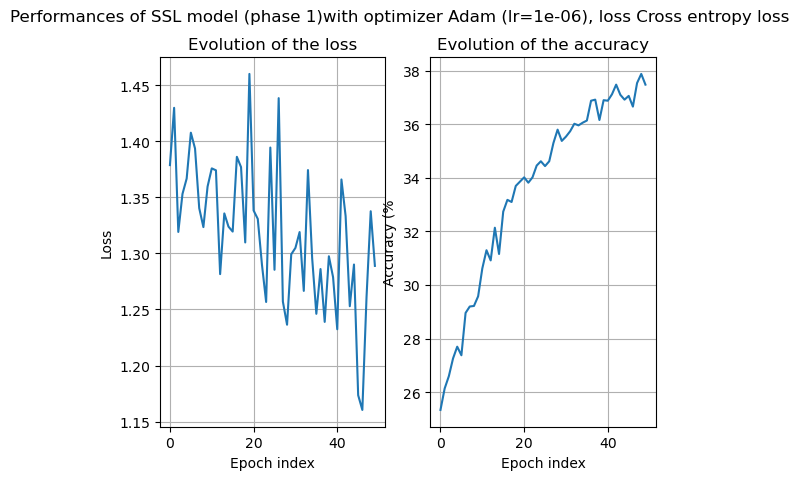

torch.Size([10000, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32])
Starting training...

The model will be running on cuda:0 device.

Epoch: 1, Cross Entropy Loss: 1.5489405393600464, accuracy: 85.86%
Epoch: 2, Cross Entropy Loss: 1.584735631942749, accuracy: 87.66%
Epoch: 3, Cross Entropy Loss: 1.5878604650497437, accuracy: 88.54%
Epoch: 4, Cross Entropy Loss: 1.5907819271087646, accuracy: 88.0%
Epoch: 5, Cross Entropy Loss: 1.4647685289382935, accuracy: 96.78%
Epoch: 6, Cross Entropy Loss: 1.5289764404296875, accuracy: 96.52%
Epoch: 7, Cross Entropy Loss: 1.4647780656814575, accuracy: 97.9%
Epoch: 8, Cross Entropy Loss: 1.524166464805603, accuracy: 98.02%
Epoch: 9, Cross Entropy Loss: 1.4629969596862793, accuracy: 98.28%
Epoch: 10, Cross Entropy Loss: 1.464698076248169, accuracy: 98.12%
Epoch: 11, Cross Entropy Loss: 1.4713780879974365, accuracy: 98.34%
Epoch: 12, Cross Entropy Loss: 1.4613549709320068, accuracy: 98.1%
Epoch: 13, Cross Entropy Loss: 1.5239036083221436, accur

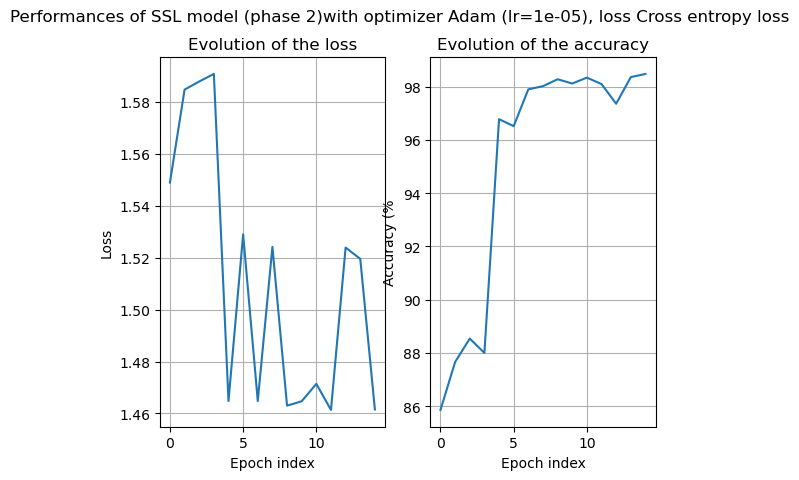

In [69]:
if __name__=="__main__":

    warnings.filterwarnings("ignore")
    main()

## Conclusion

**Phase 1:**  
During training, we noted that to much angles (aka classes) to predict provokes a vanishing gradient. The extrem limit is when we try to predict 360 classes.
When we test with four classes, with learning rate set to 1e-6, we achieve with 50 epochs an accuracy of 39%.

**Phase 2:**  
Because of the first phase where we trained convolutionnal filters on a pre-task, we start the classification with more than 90% of accuracy. Moreover, we reached a comparable accuracy with less data and in the same number of epochs. 
An explanation is that instead of instanciate the weights randomly, we begin the training with convolutional filters that are already extractingable to extract useful informations.

